In [39]:
import os
import math
import pandas as pd
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from glob import glob
import pybedtools
import re
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from scipy import stats
from statsmodels.stats.multitest import multipletests,fdrcorrection
import warnings
from tqdm import tqdm
import pickle
warnings.filterwarnings('ignore')

In [48]:
def categorise_lfc(lfc, padj):
    """
    categorise log2 fold change
    """
    if padj>0.05:
        return "NS"
    elif padj<0.05:
        if abs(lfc)<2:
            return "|lfc|>0"
        elif abs(lfc)<=6:
            return "|lfc|>2"
        elif abs(lfc)>6:
            return "|lfc|>6"
    elif pd.isna(padj):
        return "NA"
        
def process_deseq2_output(csv, merged_bambu_df):
    """
    parse deseq2 results table that has following columns:
    allele_pair, log2FoldChange, lfcSE, stat, pvalue, padj. 
    
    """
    df = pd.read_csv(csv)
    df.columns = ["allele_pair"]+list(df.columns)[1:]
    missing = merged_bambu_df[~merged_bambu_df["allele_pair_id"].isin(df["allele_pair"])]
    if not missing.empty:
        missing_rows = pd.DataFrame({
            "allele_pair": missing["allele_pair_id"],
            "log2FoldChange": np.nan,
            "lfcSE": np.nan,
            "stat": np.nan,
            "pvalue": np.nan,
            "padj": np.nan,
            "DEcategory": np.nan
        })
        df = pd.concat([df, missing_rows], ignore_index=True)
    df["DEcategory"] = df.apply(lambda row: categorise_lfc(row["log2FoldChange"], row["padj"]), axis=1)
    return df

In [49]:
merged_bambu_df_filt = pd.read_csv("allele_specific_expression/allele_paired.gene_counts.cds.FILTERED.bambu.tsv", sep="\t")

conditions = ["UG", "4dpi", "6dpi", "8dpi", "10dpi", "12dpi"]
ug_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_UG_b_vs_UG_a.csv", merged_bambu_df_filt)
dpi4_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_4dpi_b_vs_4dpi_a.csv", merged_bambu_df_filt)
dpi6_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_6dpi_b_vs_6dpi_a.csv", merged_bambu_df_filt)
dpi8_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_8dpi_b_vs_8dpi_a.csv", merged_bambu_df_filt)
dpi10_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_10dpi_b_vs_10dpi_a.csv", merged_bambu_df_filt)
dpi12_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_12dpi_b_vs_12dpi_a.csv", merged_bambu_df_filt)
allconditions_DEcategory_df = pd.concat([ug_deseq2_df["DEcategory"], 
                             dpi4_deseq2_df["DEcategory"], 
                             dpi6_deseq2_df["DEcategory"], 
                             dpi8_deseq2_df["DEcategory"], 
                             dpi10_deseq2_df["DEcategory"], 
                             dpi12_deseq2_df["DEcategory"]], 
                            axis=1, 
                            keys=conditions)

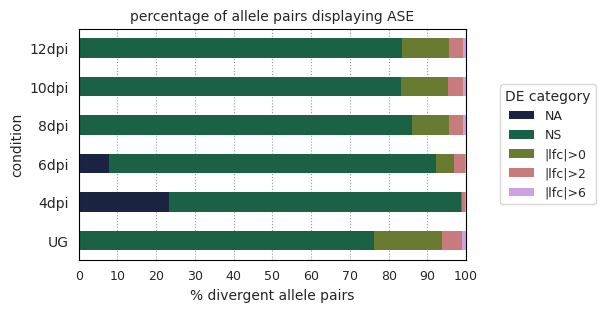

In [50]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
fig,ax = plt.subplots(figsize=(5,3))
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
percentages = allconditions_DEcategory_df.apply(pd.value_counts, normalize=True).T * 100
colors = sns.color_palette("cubehelix", n_colors=6)
percentages.plot(kind="barh", stacked=True, color=colors, ax=ax, linewidth=0)
plt.xlabel("% divergent allele pairs")
plt.ylabel("condition")
plt.title("percentage of allele pairs displaying ASE", fontsize=10)
plt.legend(title="DE category", bbox_to_anchor=(1.35, 0.5), loc="center right", ncol=1, fontsize=9)
plt.xlim(0,100)
plt.xticks(ticks=np.arange(0, 101, 10), fontsize=9)
plt.show()

In [51]:
def get_gene_id(faa):
    """
    get gene ID from faa headers' second field
    """
    out = []
    with open(faa, "r") as file:
        for n in file.readlines():
            if n.startswith(">"):
                out.append(n.split(" ")[-1].rstrip())
    return out

def log_transform_norm_count(df):
    df.reset_index(inplace=True)
    df = pd.melt(df, id_vars=["index"])
    df["log10(median_or_ratio+1)"] = np.log10(df["value"]+1)
    return df

In [52]:
HAPA_PROT = "allele_specific_expression/Puccinia_striiformis_Pst104E_hapA.proteins.fa"
HAPB_PROT = "allele_specific_expression/Puccinia_striiformis_Pst104E_hapB.proteins.fa"
a_gene_id = get_gene_id(HAPA_PROT)
b_gene_id = get_gene_id(HAPB_PROT)

# filter to keep genes (rows) that have at least four samples that have counts greater than 5, to be considered expressed.
all_genes_count_df = pd.read_csv("allele_specific_expression/all_cond.gene_counts.cds.bambu.tsv", sep="\t")
all_genes_count_df = all_genes_count_df[all_genes_count_df.iloc[:,1:].gt(5).sum(axis=1) >= 4]
expressed_gene_ids = all_genes_count_df["GENEID"].tolist()

# load deseq2-normalised transcript abundances for protein-coding gene models that show expression (defined above)
all_genes_norm_count_df = pd.read_csv("allele_specific_expression/all_cond.cds.bambu_DESeq2_norm_counts.tsv", sep="\t").reset_index()
all_genes_norm_count_df = all_genes_norm_count_df[all_genes_norm_count_df["index"].isin(expressed_gene_ids)]

# split the norm count dataframe into hapA and hapB
a_all_genes_norm_count_df = all_genes_norm_count_df[all_genes_norm_count_df["index"].isin(a_gene_id)].set_index("index")
a_transformed_norm_count = log_transform_norm_count(a_all_genes_norm_count_df)
a_transformed_norm_count["haplotype"] = "A"

b_all_genes_norm_count_df = all_genes_norm_count_df[all_genes_norm_count_df["index"].isin(b_gene_id)].set_index("index")
b_transformed_norm_count = log_transform_norm_count(b_all_genes_norm_count_df)
b_transformed_norm_count["haplotype"] = "B"

all_genes_transformed_norm_count = pd.concat([a_transformed_norm_count, b_transformed_norm_count], axis=0)
len(all_genes_transformed_norm_count["index"].unique())

19346

In [53]:
a_vals = np.array(a_transformed_norm_count["log10(median_or_ratio+1)"])
b_vals = np.array(b_transformed_norm_count["log10(median_or_ratio+1)"])

# test if the transformed normalisation count values are normally distributed.
for array in [a_vals, b_vals]:
    stat, pvalue = stats.normaltest(array)
    print(f"normality test stats: {stat}, pvalue: {pvalue}")
    if pvalue < 0.05:
        print("normality test pvalue < 0.05, reject null. not normally distributed.")
        
# since both arrays do not follow normality use the nonparametric mann whitney test.
mwstat, pval = stats.mannwhitneyu(a_vals, b_vals)
print(f"MannWhiteneyU stats: {mwstat}, pvalue: {pval}")
if pval < 0.05:
    print("pvalue < 0.05, reject null.")
else:
    print("pvalue >= 0.05, accept null.")

normality test stats: 2647.223680651712, pvalue: 0.0
normality test pvalue < 0.05, reject null. not normally distributed.
normality test stats: 2305.7653028129725, pvalue: 0.0
normality test pvalue < 0.05, reject null. not normally distributed.
MannWhiteneyU stats: 27095706047.5, pvalue: 0.0009191442621157717
pvalue < 0.05, reject null.


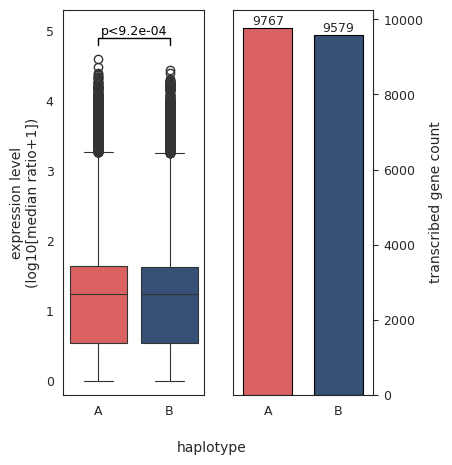

In [54]:
sns.set_style("white")
fig,ax = plt.subplots(1,2,figsize=(4,5))
color=["#ee4e4e", "#2c4e80"]
palette = {"A": color[0], "B": color[1]}
#ax[0]
sns.boxplot(all_genes_transformed_norm_count, y="log10(median_or_ratio+1)", x="haplotype", ax=ax[0], linewidth=0.8, palette=palette)
ax[0].set_ylabel("expression level\n(log10[median ratio+1])")
ax[0].set_xlabel("haplotype")
ax[0].xaxis.set_label_coords(1.05, -0.12)
ax[0].tick_params(axis='both', labelsize=9)

#ax[1]
sns.barplot(pd.DataFrame({"A":[len(a_all_genes_norm_count_df)],"B":[len(b_all_genes_norm_count_df)]}), ax=ax[1], edgecolor="k", linewidth=0.8, palette=palette, width=0.7)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel("transcribed gene count")
ax[1].tick_params(axis='both', labelsize=9)

for p in ax[1].patches:
    ax[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

x1,x2 = 0,1
y,h,col = all_genes_transformed_norm_count["log10(median_or_ratio+1)"].max() + 0.2,0.1,"k"
ax[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
ax[0].set_ylim(-0.2,5.3)
ax[0].text((x1+x2)*.5, y+h, "p<9.2e-04", ha='center', va='bottom', color=col, fontsize=9)
plt.show()

In [55]:
def obtain_ASE_and_nonASE_pairs(raw_deseq2_df):
    """
    filter raw deseq2 result df to obtain allele pairs displaying allele-specific expression.
    input: df from process_deseq2_output.
    output: two deseq2 dataframe sliced based on ASE or nonASE according to the filter applied.
    """
    df = raw_deseq2_df
    df[["alleleA", "alleleB"]] = df["allele_pair"].str.split(":", expand=True)
    ASE_df = df[(np.absolute(df["log2FoldChange"])>=2)&(df["padj"]<0.05)]
    nonASE_df = df[(np.absolute(df["log2FoldChange"])<2)]
    return ASE_df, nonASE_df

def filter_genes_by_ASE_status(ase_status_df, query_gene_list, ase_status):
    assert ase_status == "ASE" or ase_status == "nonASE"
    ase_status_allele_pairs = ase_status_df["allele_pair"].tolist()
    results = []
    for gene_pair in ase_status_allele_pairs:
        geneA, geneB = gene_pair.split(":")
        if geneA in query_gene_list or geneB in query_gene_list:
            results.append(gene_pair)
    print(f"query genes in the {ase_status} category: {len(results)*2}")
    print(f"{len(results)*2}/{len(ase_status_allele_pairs)} = {len(results)*2/len(ase_status_allele_pairs)}")
    return results, len(results)*2

def remove_overlaps(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    unique_list1 = list(set1 - set2)  # elements in list1 but not in list2
    unique_list2 = list(set2 - set1)  # elements in list2 but not in list1
    return unique_list1, unique_list2

In [56]:
# load DEseq2 result dataframe.
ug_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_UG_b_vs_UG_a.csv", merged_bambu_df_filt)
dpi4_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_4dpi_b_vs_4dpi_a.csv", merged_bambu_df_filt)
dpi6_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_6dpi_b_vs_6dpi_a.csv", merged_bambu_df_filt)
dpi8_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_8dpi_b_vs_8dpi_a.csv", merged_bambu_df_filt)
dpi10_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_10dpi_b_vs_10dpi_a.csv", merged_bambu_df_filt)
dpi12_deseq2_df = process_deseq2_output("allele_specific_expression/DESeq2_results_table/condition_12dpi_b_vs_12dpi_a.csv", merged_bambu_df_filt)

# filter deseq2 df by padj & log2FoldChange, then divide into ASE and non-ASE deseq2 df. 
ug_ASE, ug_nonASE = obtain_ASE_and_nonASE_pairs(ug_deseq2_df)
dpi4_ASE, dpi4_nonASE = obtain_ASE_and_nonASE_pairs(dpi4_deseq2_df)
dpi6_ASE, dpi6_nonASE = obtain_ASE_and_nonASE_pairs(dpi6_deseq2_df)
dpi8_ASE, dpi8_nonASE = obtain_ASE_and_nonASE_pairs(dpi8_deseq2_df)
dpi10_ASE, dpi10_nonASE = obtain_ASE_and_nonASE_pairs(dpi10_deseq2_df)
dpi12_ASE, dpi12_nonASE = obtain_ASE_and_nonASE_pairs(dpi12_deseq2_df)

In [57]:
# load complete busco gene id
busco_df = pd.read_csv("ase_functional_enrichment/busco/busco_full_table.csv", sep="\t", header=None)
busco_df.columns = "Busco_id      Status  Sequence        Score   Length  OrthoDB_url     Description".split()
busco_df = busco_df[busco_df["Status"] == "Complete"]
busco_df["Sequence"] = busco_df["Sequence"].apply(lambda x: x[:-3])
busco_gene_id = busco_df["Sequence"].tolist()

# load secretome/effector gff3
seceff_df = pd.read_csv("secretome_effector_candidates/Puccinia_striiformis_Pst104E.secretome-effectors.TM_anno_cleaned.gff3", sep="\t", header=None)
seceff_df.columns = ["chr", "method", "type", "start", "end", "strand", "func_anno", "gene_id"]
seceff_gene_id = seceff_df["gene_id"].tolist()
print(f"number of gene ids: {len(seceff_gene_id)}, {len(busco_gene_id)}")

# remove overlaps between busco and secretome/effector genes.
seceff_gene_id, busco_gene_id = remove_overlaps(seceff_gene_id, busco_gene_id)
print(f"number of filtered gene ids after removing overlaps:\n secreomte/effectors: {len(seceff_gene_id)}, busco: {len(busco_gene_id)}")
seceff_gene_id = [x for x in seceff_gene_id if x in expressed_gene_ids]
busco_gene_id = [x for x in busco_gene_id if x in expressed_gene_ids]
print(f"number of filtered gene ids based on transcript abundance:\n secreomte/effectors: {len(seceff_gene_id)}, busco: {len(busco_gene_id)}")

number of gene ids: 4537, 3122
number of filtered gene ids after removing overlaps:
 secreomte/effectors: 4511, busco: 3096
number of filtered gene ids based on transcript abundance:
 secreomte/effectors: 2492, busco: 3095


In [58]:
print("### BUSCO ###")
print("UG")
busco_ug_ASE_genes, busco_ug_ASE_genes_num = filter_genes_by_ASE_status(ug_ASE, busco_gene_id, "ASE")
busco_ug_nonASE_genes, busco_ug_nonASE_genes_num = filter_genes_by_ASE_status(ug_nonASE, busco_gene_id, "nonASE")
print("\n4dpi")
busco_dpi4_ASE_genes, busco_dpi4_ASE_genes_num = filter_genes_by_ASE_status(dpi4_ASE, busco_gene_id, "ASE")
busco_dpi4_nonASE_genes, busco_dpi4_nonASE_genes_num = filter_genes_by_ASE_status(dpi4_nonASE, busco_gene_id, "nonASE")
print("\n6dpi")
busco_dpi6_ASE_genes, busco_dpi6_ASE_genes_num = filter_genes_by_ASE_status(dpi6_ASE, busco_gene_id, "ASE")
busco_dpi6_nonASE_genes, busco_dpi6_nonASE_genes_num = filter_genes_by_ASE_status(dpi6_nonASE, busco_gene_id, "nonASE")
print("\n8dpi")
busco_dpi8_ASE_genes, busco_dpi8_ASE_genes_num = filter_genes_by_ASE_status(dpi8_ASE, busco_gene_id, "ASE")
busco_dpi8_nonASE_genes, busco_dpi8_nonASE_genes_num = filter_genes_by_ASE_status(dpi8_nonASE, busco_gene_id, "nonASE")
print("\n10dpi")
busco_dpi10_ASE_genes, busco_dpi10_ASE_genes_num = filter_genes_by_ASE_status(dpi10_ASE, busco_gene_id, "ASE")
busco_dpi10_nonASE_genes, busco_dpi10_nonASE_genes_num = filter_genes_by_ASE_status(dpi10_nonASE, busco_gene_id, "nonASE")
print("\n12dpi")
busco_dpi12_ASE_genes, busco_dpi12_ASE_genes_num = filter_genes_by_ASE_status(dpi12_ASE, busco_gene_id, "ASE")
busco_dpi12_nonASE_genes, busco_dpi12_nonASE_genes_num = filter_genes_by_ASE_status(dpi12_nonASE, busco_gene_id, "nonASE")

# secretome/effector genes that show ASE or nonASE, at ug and 12dpi
print("\n------------\n### SECRETOME/EFFECTORS ###")
print("UG")
seceff_ug_ASE_genes, seceff_ug_ASE_genes_num = filter_genes_by_ASE_status(ug_ASE, seceff_gene_id, "ASE")
seceff_ug_nonASE_genes, seceff_ug_nonASE_genes_num = filter_genes_by_ASE_status(ug_nonASE, seceff_gene_id, "nonASE")
print("\n4dpi")
seceff_dpi4_ASE_genes, seceff_dpi4_ASE_genes_num = filter_genes_by_ASE_status(dpi4_ASE, seceff_gene_id, "ASE")
seceff_dpi4_nonASE_genes, seceff_dpi4_nonASE_genes_num = filter_genes_by_ASE_status(dpi4_nonASE, seceff_gene_id, "nonASE")
print("\n6dpi")
seceff_dpi6_ASE_genes, seceff_dpi6_ASE_genes_num = filter_genes_by_ASE_status(dpi6_ASE, seceff_gene_id, "ASE")
seceff_dpi6_nonASE_genes, seceff_dpi6_nonASE_genes_num = filter_genes_by_ASE_status(dpi6_nonASE, seceff_gene_id, "nonASE")
print("\n8dpi")
seceff_dpi8_ASE_genes, seceff_dpi8_ASE_genes_num = filter_genes_by_ASE_status(dpi8_ASE, seceff_gene_id, "ASE")
seceff_dpi8_nonASE_genes, seceff_dpi8_nonASE_genes_num = filter_genes_by_ASE_status(dpi8_nonASE, seceff_gene_id, "nonASE")
print("\n10dpi")
seceff_dpi10_ASE_genes, seceff_dpi10_ASE_genes_num = filter_genes_by_ASE_status(dpi10_ASE, seceff_gene_id, "ASE")
seceff_dpi10_nonASE_genes, seceff_dpi10_nonASE_genes_num = filter_genes_by_ASE_status(dpi10_nonASE, seceff_gene_id, "nonASE")
print("\n12dpi")
seceff_dpi12_ASE_genes, seceff_dpi12_ASE_genes_num = filter_genes_by_ASE_status(dpi12_ASE, seceff_gene_id, "ASE")
seceff_dpi12_nonASE_genes, seceff_dpi12_nonASE_genes_num = filter_genes_by_ASE_status(dpi12_nonASE, seceff_gene_id, "nonASE")

### BUSCO ###
UG
query genes in the ASE category: 28
28/406 = 0.06896551724137931
query genes in the nonASE category: 2394
2394/5893 = 0.40624469709825217

4dpi
query genes in the ASE category: 18
18/74 = 0.24324324324324326
query genes in the nonASE category: 2246
2246/5850 = 0.38393162393162394

6dpi
query genes in the ASE category: 24
24/205 = 0.11707317073170732
query genes in the nonASE category: 2394
2394/6049 = 0.39576789551992064

8dpi
query genes in the ASE category: 24
24/290 = 0.08275862068965517
query genes in the nonASE category: 2394
2394/5980 = 0.4003344481605351

10dpi
query genes in the ASE category: 20
20/300 = 0.06666666666666667
query genes in the nonASE category: 2400
2400/6041 = 0.39728521767919217

12dpi
query genes in the ASE category: 18
18/292 = 0.06164383561643835
query genes in the nonASE category: 2404
2404/6073 = 0.3958504857566277

------------
### SECRETOME/EFFECTORS ###
UG
query genes in the ASE category: 202
202/406 = 0.4975369458128079
query genes in 

In [59]:
# H0: Gene category is independent upon ASE status.
# Ha: Gene category is not independent upon ASE status.

results_dir = {}

print("UG")
contingency_table = np.array([[seceff_ug_ASE_genes_num, busco_ug_ASE_genes_num],\
                              [seceff_ug_nonASE_genes_num, busco_ug_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["UG"] = fisher_res

print("4dpi")
contingency_table = np.array([[seceff_dpi4_ASE_genes_num, busco_dpi4_ASE_genes_num],\
                              [seceff_dpi4_nonASE_genes_num, busco_dpi4_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["4dpi"] = fisher_res

print("6dpi")
contingency_table = np.array([[seceff_dpi6_ASE_genes_num, busco_dpi6_ASE_genes_num],\
                              [seceff_dpi6_nonASE_genes_num, busco_dpi6_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["6dpi"] = fisher_res

print("8dpi")
contingency_table = np.array([[seceff_dpi8_ASE_genes_num, busco_dpi8_ASE_genes_num],\
                              [seceff_dpi8_nonASE_genes_num, busco_dpi8_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["8dpi"] = fisher_res

print("10dpi")
contingency_table = np.array([[seceff_dpi10_ASE_genes_num, busco_dpi10_ASE_genes_num],\
                              [seceff_dpi10_nonASE_genes_num, busco_dpi10_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["10dpi"] = fisher_res

print("12dpi")
contingency_table = np.array([[seceff_dpi12_ASE_genes_num, busco_dpi12_ASE_genes_num],\
                              [seceff_dpi12_nonASE_genes_num, busco_dpi12_nonASE_genes_num]])
fisher_res = stats.fisher_exact(contingency_table)
print(fisher_res)
results_dir["12dpi"] = fisher_res

fisher_res_df = pd.DataFrame.from_dict(results_dir, orient='index', columns=['odds ratio', 'pval']).reset_index()
fisher_res_df["pval"] = -(np.log10(fisher_res_df["pval"]))
fisher_res_df.columns = ["condition", "odds ratio", "-log10(p-value)"]
fisher_res_df["isSigf"] = np.where(fisher_res_df["-log10(p-value)"]>-(np.log10(0.05)), "yes", "no")
fisher_res_df

UG
(11.977115117891817, 2.691782686861981e-53)
4dpi
(2.0251075045082536, 0.02140446192344511)
6dpi
(5.505256241787122, 6.092535036378521e-16)
8dpi
(11.174180327868852, 1.3941183261369069e-42)
10dpi
(15.849056603773585, 5.476228658974549e-56)
12dpi
(14.780851998243303, 4.763096916174372e-47)


,condition,odds ratio,-log10(p-value),isSigf
0,UG,11.977115,52.569960,yes
1,4dpi,2.025108,1.669496,yes
2,6dpi,5.505256,15.215202,yes
3,8dpi,11.174180,41.855700,yes
4,10dpi,15.849057,55.261518,yes
5,12dpi,14.780852,46.322111,yes


Text(0.5, 1.0, 'Enrichment of secretome genes\nfor ASE genes compared to BUSCOs')

<Figure size 640x480 with 0 Axes>

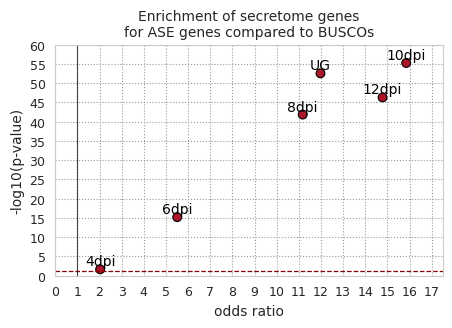

In [60]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.despine(left=True)
palette = list(sns.color_palette("RdBu",10))
palette = [palette[0],"darkgrey"]
plt.figure(figsize=(5,3))
sns.scatterplot(fisher_res_df, x="odds ratio", y="-log10(p-value)", hue="isSigf", s=40, palette=palette, legend=False, linewidth=0.8, edgecolor="black")
for i in range(fisher_res_df.shape[0]):
    plt.text(fisher_res_df["odds ratio"][i], fisher_res_df["-log10(p-value)"][i]+1, fisher_res_df["condition"][i], 
             horizontalalignment="center", size="medium", color="black")

plt.axhline(y=-np.log10(0.05), color="darkred", linestyle='--', linewidth=0.9)
plt.axvline(x=1, color="black", linewidth=0.8, alpha=0.7)
plt.xticks(ticks=np.arange(0, 21, 1), fontsize=9)
plt.yticks(ticks=np.arange(0, 61, 5), fontsize=9)
plt.ylim(0,60)
plt.xlim(0,17.5)
plt.title("Enrichment of secretome genes\nfor ASE genes compared to BUSCOs", fontsize=10)

In [61]:
def flatten_allele_pairs(lst):
    """
    split input list [allele1a:allele1b, allele2a:allele2b] into allele1a, allele1b, allele2a, allele2b
    for the first column 'gene' of the deseq2 result table.
    """
    alist = [n.split(":") for n in lst]
    return [m for n in alist for m in n]

def read_gff3(gff3_fn):
    """
    convert gff3 to df
    """
    gff3 = pd.read_csv(gff3_fn, sep="\t", header=None)
    gff3.columns = ["chr", "source", "type", "start", "end", "score", "strand", "phase", "attr"]
    return gff3

def extract_cds_in_gff3(gff3_df):
    """
    reads in a gff3 dataframe and filter for only CDS coordinates.
    creates new column gene_id to store identifier.
    """
    gff3_df["gene_id"] = gff3_df["attr"].apply(lambda x: x.split("Parent=")[-1].split(";")[0].split("-T1")[0].split("ID=")[-1])
    return gff3_df[gff3_df["type"]=="CDS"]

def get_flanking_region(target_gff, flank):
    """
    reads in a target df and finds the coordinates of 5'/3' flanking regions (strand-aware) with lengths specified by user.
    returns 3 dicts containing the start & end coordinates of target (eg genebody), 5' flank, 3' flank
    """
    assert type(flank) == int
    genebody_dict = {}
    fiveprime_flank_dict = {}
    threeprime_flank_dict = {}
    for gene in target_gff["gene_id"].unique():
        tmp = target_gff[target_gff["gene_id"]==gene]
        chrom = tmp["chr"].iloc[0]
        strand = tmp["strand"].iloc[0]
        start = tmp["start"].min()-1
        end = tmp["end"].max()
        genebody_dict[gene] = [chrom, start, end, gene, 0, strand]
        if strand == "+":
            fiveprime_flank_dict[gene] = [chrom, start-flank, start, gene, 0, strand]
            threeprime_flank_dict[gene] = [chrom, end, end+flank, gene, 0, strand]
        if strand == "-":
            fiveprime_flank_dict[gene] = [chrom, end, end+flank, gene, 0, strand]
            threeprime_flank_dict[gene] = [chrom, start-flank, start, gene, 0, strand]
    print("number of processed targets: ", len(genebody_dict))
    assert len(genebody_dict)==len(fiveprime_flank_dict) & len(genebody_dict)==len(threeprime_flank_dict)
    return genebody_dict, fiveprime_flank_dict, threeprime_flank_dict

def read_bedmethyl(file):
    """
    convert bedmethyl into df
    """
    cpgmeth = pd.read_csv(file, sep="\t", header=None)
    cpgmeth.columns = ["chr", "start", "end", "methfrac", "coverage"]
    return cpgmeth

def get_upreg_to_alt_allele_pair_dict(df):
    """
    takes in a processed deseq2 df and split alleles from names in allele_pair column.
    the allele_pair should be named as ref:query.
    then use log2FoldChange column to decide whether ref or query was upregulated based on +/-
    output directory would be {upregulated_allele_1a: alternate_allele_1b,
                                upregulated_allele_2b: alternate_allele_2a, ...}
    """
    assert len(df["allele_pair"].unique()) == len(df["allele_pair"])
    outdict = {}
    for _, row in df.iterrows():
        allele_a, allele_b = row["allele_pair"].split(":")
        if row["log2FoldChange"] > 0:
            upreg_allele = allele_b
            outdict[upreg_allele] = allele_a
        elif row["log2FoldChange"] < 0:
            upreg_allele = allele_a
            outdict[upreg_allele] = allele_b
        upreg_alleles = outdict.keys()
        alt_alleles = outdict.values()
    return outdict, upreg_alleles, alt_alleles

def create_gene_region_df(gene_component_region, upreg_alt_dict):
    gene_component_region.columns = ["chr","start","end","name","score","strand", "gene"]
    gene_component_region.drop(columns=["name"], axis=1, inplace=True)
    return gene_component_region[gene_component_region["gene"].isin(list(upreg_alt_dict.keys())+list(upreg_alt_dict.values()))]
    
def classify_upreg_alt_in_allele_bed_df(gene_component_category_dict, upreg_alt_dict, deseq2_df):
    df = create_gene_region_df(gene_component_category_dict, upreg_alt_dict)
    upreg = list(upreg_alt_dict.keys())
    alt = list(upreg_alt_dict.values())
    tmp = []
    for _, row in df.iterrows():
        if row["gene"] in upreg:
            row["counterpart"] = upreg_alt_dict[row["gene"]]
            match = deseq2_df[deseq2_df["allele_pair"].str.contains(str(row["gene"]))]
            category = categorise_lfc(match["log2FoldChange"].iloc[0], match["padj"].iloc[0])
            row["status"] = category
            row["abs_log2FoldChange"] = abs(match["log2FoldChange"].iloc[0])
            tmp.append(row)
        elif row["gene"] in alt:
            row["counterpart"] = list(upreg_alt_dict.keys()) [list(upreg_alt_dict.values()).index(row["gene"])]
            row["status"] = "alt"
            row["abs_log2FoldChange"] = "alt"
            tmp.append(row)
    newdf = pd.DataFrame(tmp)
    newdf["length"] = newdf["end"]-newdf["start"]
    return newdf

def bin_allele_into_equal_bin_num(df, bin_num=20):
    result = []
    for _, allele_row in df.iterrows():
        length = allele_row["length"]
        bin_size = length/bin_num
        for bin_id in range(1, bin_num+1):
            bin_start = allele_row["start"]+(bin_id-1) * bin_size
            bin_end = bin_start + bin_size
            new_row = allele_row.to_dict()
            if allele_row["strand"] == "+":
                new_row["bin_id"] = bin_id
            else:
                new_row["bin_id"] =  bin_num+1 - bin_id  # flip bin_id for negative strand
            new_row["bin_start"] = bin_start
            new_row["bin_end"] = bin_end
            result.append(new_row)
    return pd.DataFrame(result)

def get_mean_meth_density_per_bin(df, meth_df, progress_report_interval=100):
    df["methylation_density"] = 0
    for i, row in tqdm(df.iterrows(), total=df.shape[0], desc="Calculating Methylation Density", unit="row"):
        chr_filter = meth_df['chr'] == row['chr']
        start_filter = meth_df['start'] >= row['bin_start']
        end_filter = meth_df['end'] <= row['bin_end']
        filtered_meth_df = meth_df[chr_filter & start_filter & end_filter]
        if not filtered_meth_df.empty:
            methylation_density = filtered_meth_df['methfrac'].mean()
        else:
            methylation_density = 0
        df.at[i, 'methylation_density'] = methylation_density
        
    return df

def generate_genebody_and_5_3_flank_cooordinates(allele_pair_list, cds_gff3_df, output_bed_prefix, flank_length=2000):
    """
    generates coordinates of genebody, 5' (from ATG) and 3' (from termination) flanking sequences. 
    for negative strands the start position will be flipped around to keep 5'/3' directionality (by function get_flanking_region).
    
    takes in (1) allele pair ID list and (2) a CDS gff3 dataframe
    input:
    1. allele_pair_list: list of allele pair IDs written as [allele1a:allele1b, allele2a:allele2b ...]
    2. cds_gff3_df: pandas df of cds.
    3. output_bed_prefix: prefix for three bed files (genebody, 5' and 3' flanks) to write coordinates to.
    4. flank_length: length of flanking sequences, 2000bp by default.
    """
    flattened_allele_list = flatten_allele_pairs(allele_pair_list)
    target_allele_cds_gff3 = cds_gff3[cds_gff3["gene_id"].isin(flattened_allele_list)]
    genebody_info_dict, flank5_info_dict, flank3_info_dict = get_flanking_region(target_allele_cds_gff3, flank_length)
    name = [f"5prime_{str(flank_length)}bp", "genebody", f"3prime_{str(flank_length)}bp"]
    results = []
    for i,x in enumerate([flank5_info_dict, genebody_info_dict, flank3_info_dict]):
        df = pd.DataFrame.from_dict(x, orient="index").reset_index()
        df["gene"] = df["index"]
        df = df.iloc[:,1:]
        df.columns = ["chr", "start", "end", "name", "score", "strand", "gene_id"]
        df.to_csv(f"{output_bed_prefix}.{name[i]}.coords.bed", header=None, index=None, sep="\t")
        results.append(df)
    print("output dataframes order\n 0:flank5, 1:genebody, 2:flank3\n")
    return results

def compute_methylation_across_all_features(gene_feature_classified_dflist, meth_df, bin_num=20):
    result = []
    for i,df in enumerate(gene_feature_classified_dflist):
        tmp = bin_allele_into_equal_bin_num(df, bin_num)
        methtmp = get_mean_meth_density_per_bin(tmp, meth_df)
        if i==1:
            print(methtmp["bin_id"])
            methtmp["bin_id"] = methtmp["bin_id"]+bin_num
        if i==2:
            methtmp["bin_id"] = methtmp["bin_id"]+(bin_num*2) 
        result.append(methtmp)
    return pd.concat(result)

def analyse_5prime_genebody_3prime_methylation(target_allele_pairs, cds_gff3, gene_region_outbed_prefix, filt_deseq2_df, meth_df):
    flank5, genebody, flank3 = generate_genebody_and_5_3_flank_cooordinates(target_allele_pairs, cds_gff3, gene_region_outbed_prefix)
    ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(filt_deseq2_df)
    
    flank5_classified = classify_upreg_alt_in_allele_bed_df(flank5, ase_dict, filt_deseq2_df)
    genebody_classified = classify_upreg_alt_in_allele_bed_df(genebody, ase_dict, filt_deseq2_df)
    flank3_classified = classify_upreg_alt_in_allele_bed_df(flank3, ase_dict, filt_deseq2_df)
    results = compute_methylation_across_all_features([flank5_classified,genebody_classified,flank3_classified], meth_df)
    return results

In [162]:
# tasks = [
#     ("seceff_ASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_ug_ASE_genes, cds_gff3, "seceff_ASE_UG_alleles", ug_ASE, meth_df)),
#     ("seceff_ASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi12_ASE_genes, cds_gff3, "seceff_ASE_dpi12_alleles", dpi12_ASE, meth_df)),
#     ("busco_ASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (busco_ug_ASE_genes, cds_gff3, "busco_ASE_UG_alleles", ug_ASE, meth_df)),
#     ("busco_ASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi12_ASE_genes, cds_gff3, "busco_ASE_dpi12_alleles", dpi12_ASE, meth_df)),
#     ("seceff_nonASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_ug_nonASE_genes, cds_gff3, "seceff_nonASE_UG_alleles", ug_nonASE, meth_df)),
#     ("seceff_nonASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (seceff_dpi12_nonASE_genes, cds_gff3, "seceff_nonASE_dpi12_alleles", dpi12_nonASE, meth_df)),
#     ("busco_nonASE_UG_alleles", analyse_5prime_genebody_3prime_methylation, (busco_ug_nonASE_genes, cds_gff3, "busco_nonASE_UG_alleles", ug_nonASE, meth_df)),
#     ("busco_nonASE_dpi12_alleles", analyse_5prime_genebody_3prime_methylation, (busco_dpi12_nonASE_genes, cds_gff3, "busco_nonASE_dpi12_alleles", dpi12_nonASE, meth_df))
# ]


# def run_task(func, args):
#     return func(*args)

# with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
#     future_to_task = {executor.submit(run_task, func, args): identifier for identifier, func, args in tasks}
    
#     results = {}
#     for future in concurrent.futures.as_completed(future_to_task):
#         task_id = future_to_task[future]
#         try:
#             result = future.result()
#             results[task_id] = result
#         except Exception as exc:
#             results[task_id] = f"Generated an exception: {exc}"

# for task_id, result in results.items():
#     print(f"Task {task_id}: {result}")

# with open('meth_results.pickle', 'wb') as f:
#    pickle.dump(results, f)

### methylation density

In [193]:
def plot_methylation_density(datasets_dict):
    """
    Plots methylation density for given datasets in a 2x2 subplot layout with a shared legend.
    
    Parameters:
    datasets_dict (dict): A dictionary where keys are titles and values are DataFrames.
                          Example: {"Title1": df1, "Title2": df2, ...}
    """
    datasets = [(key, val) for key, val in datasets_dict.items()]
    fig, axs = plt.subplots(2, 2, figsize=(6, 4))
    
    for ax, (title, df) in zip(axs.ravel(), datasets):
        df["category"] = df["status"].apply(lambda status: "differentially expressed allele" if status.startswith('|lfc|') else "reference allele" if status == 'alt' else None)
        df["methylation_density"] = df["methylation_density"] * 100
        sns.lineplot(data=df, x="bin_id", y="methylation_density", hue="category", palette="viridis", hue_order=["reference allele", "differentially expressed allele"], ax=ax)
        ax.set(xlabel=None, xticks=[])
        ax.axvline(x=20, color='grey', linestyle='dotted')
        ax.axvline(x=40, color='grey', linestyle='dotted')
        ax.text(0, -0.1, "-2kb", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
        ax.text(20, -0.1, "TSS", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
        ax.text(40, -0.1, "TTS", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
        ax.text(60, -0.1, "+2kb", ha='center', fontsize=9, transform=ax.get_xaxis_transform())
        ax.set_title(title, fontsize=10)
        handles, labels = ax.get_legend_handles_labels()
        
        num_of_genes = len(df["gene"].unique())
        ax.text(0.99, 0.99, f'n={num_of_genes}', ha='right', va='top', fontsize=9, transform=ax.transAxes)
        
    for ax in axs.ravel():
        ax.get_legend().remove()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=9)
    # Adjust layout and add legend
    plt.tight_layout()
    plt.show()

def reorder_dict(d, order):
    sorted_items = sorted(d.items(), key=lambda item: next((i for i, keyword in enumerate(order) if keyword in item[0]), float('inf')))
    return dict(sorted_items)

In [194]:
with open('meth_results.pickle', 'rb') as f:
    results = pickle.load(f)
desired_order = ["ASE_dpi12", "nonASE_dpi12", "ASE_UG", "nonASE_UG"]
busco_meth_results_dict = reorder_dict({k: v for k, v in results.items() if k.startswith("busco")}, desired_order)
seceff_meth_results_dict = reorder_dict({k: v for k, v in results.items() if k.startswith("seceff")}, desired_order)

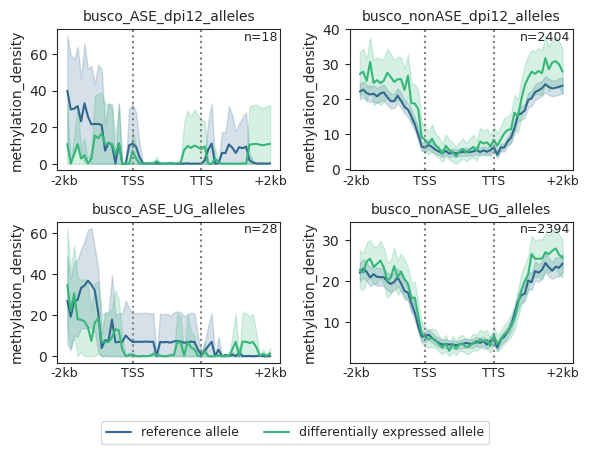

In [196]:
plot_methylation_density(busco_meth_results_dict)

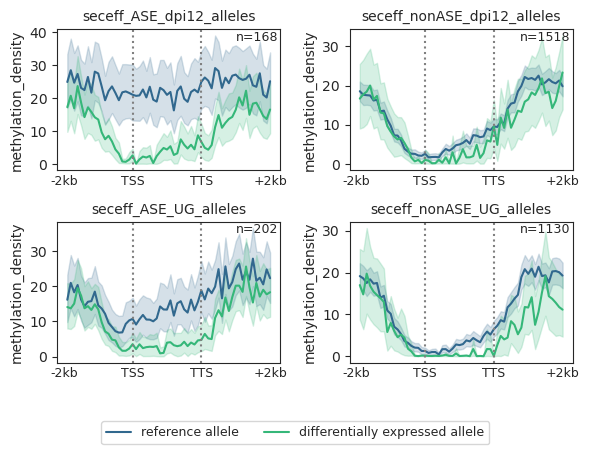

In [195]:
plot_methylation_density(seceff_meth_results_dict)

In [63]:
# get 5' and 3' flanking sequences 5kbp
gff3 = read_gff3("methylation/Puccinia_striiformis_Pst104E.gff3")
cds_gff3 = extract_cds_in_gff3(gff3)
flank5, genebody, flank3 = generate_genebody_and_5_3_flank_cooordinates(seceff_dpi12_ASE_genes, cds_gff3, "TE_occupancy/seceff_ASE_dpi12_alleles", flank_length=5000)
ase_dict, upreg, alt = get_upreg_to_alt_allele_pair_dict(dpi12_ASE)
flank5_classified = classify_upreg_alt_in_allele_bed_df(flank5, ase_dict, dpi12_ASE)
genebody_classified = classify_upreg_alt_in_allele_bed_df(genebody, ase_dict, dpi12_ASE)
flank3_classified = classify_upreg_alt_in_allele_bed_df(flank3, ase_dict, dpi12_ASE)

number of processed targets:  168
output dataframes order
 0:flank5, 1:genebody, 2:flank3



In [64]:
df5 = pd.read_csv("TE_occupancy/seceff_ASE_dpi12_alleles.5prime_2000bp.TEoverlap.bed", sep="\t", header=None, usecols=(0,1,2,3,8,9,10))
df5.columns = ["chr", "feat_start", "feat_end", "gene", "te_start", "te_end", "te_overlap_bp"]
df5 = df5.groupby(["gene"])["te_overlap_bp"].sum().reset_index()
df5 = pd.merge(df5[["gene", "te_overlap_bp"]], genebody_classified[["gene","chr","start","end", "status","abs_log2FoldChange"]], how="right", on="gene").fillna(0)
df5["site"] = "5'"
df5

df3 = pd.read_csv("TE_occupancy/seceff_ASE_dpi12_alleles.3prime_2000bp.TEoverlap.bed", sep="\t", header=None, usecols=(0,1,2,3,8,9,10))
df3.columns = ["chr", "feat_start", "feat_end", "gene", "te_start", "te_end", "te_overlap_bp"]
df3 = df3.groupby("gene")["te_overlap_bp"].sum().reset_index()
df3 = pd.merge(df3[["gene", "te_overlap_bp"]], genebody_classified[["gene","chr","start","end", "status","abs_log2FoldChange"]], how="right", on="gene").fillna(0)
df3["site"] = "3'"
df3

df = pd.concat([df5,df3])
df

,gene,te_overlap_bp,chr,start,end,status,abs_log2FoldChange,site
0,Pst104E137_000209,219.0,chr1A,892407,893685,|lfc|>2,3.96539,5'
1,Pst104E137_000354,58.0,chr1A,1565354,1565570,|lfc|>2,4.410513,5'
2,Pst104E137_000459,647.0,chr1A,2285660,2286921,|lfc|>6,6.785531,5'
3,Pst104E137_000547,1046.0,chr1A,2510782,2511869,|lfc|>2,3.117851,5'
4,Pst104E137_000797,1378.0,chr1A,3639638,3640385,|lfc|>2,5.411701,5'
...,...,...,...,...,...,...,...,...
163,Pst104E137_029362,59.0,chr15B,2799705,2800165,alt,alt,3'
164,Pst104E137_029376,0.0,chr15B,2893332,2893485,alt,alt,3'
165,Pst104E137_029469,317.0,chr16B,370020,371248,|lfc|>2,5.510194,3'
166,Pst104E137_030211,1370.0,chr17B,1124483,1126712,alt,alt,3'


In [65]:
df["status"].value_counts()

status
alt        168
|lfc|>2    134
|lfc|>6     34
Name: count, dtype: int64

<Axes: xlabel='status', ylabel='te_overlap_bp'>

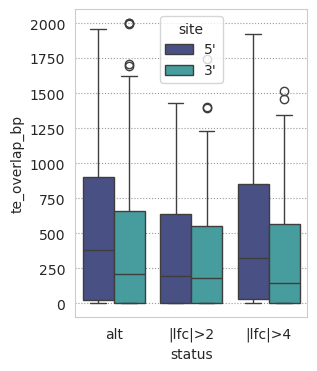

In [47]:
plt.figure(figsize=(3,4))
sns.boxplot(data=df, 
            x="status", y="te_overlap_bp", hue="site", orient="v", palette="mako",
           order=["alt", "|lfc|>2", "|lfc|>6"])

#### TE occupancy

1. merge overlapping TEs
2. get 5' and 3' flanking sequences 5kbp
3. find TE coverage at 5'
4. find TE coverage at 3'
5. plot